In [1]:
import sys
print(sys.executable)
print(sys.path)

/uufs/chpc.utah.edu/common/home/u0035056/anaconda3/envs/atmos6010/bin/python
['/uufs/chpc.utah.edu/common/home/u0035056/atmos6010/notebooks', '/uufs/chpc.utah.edu/common/home/u0035056/anaconda3/envs/atmos6010/lib/python37.zip', '/uufs/chpc.utah.edu/common/home/u0035056/anaconda3/envs/atmos6010/lib/python3.7', '/uufs/chpc.utah.edu/common/home/u0035056/anaconda3/envs/atmos6010/lib/python3.7/lib-dynload', '', '/uufs/chpc.utah.edu/common/home/u0035056/anaconda3/envs/atmos6010/lib/python3.7/site-packages', '/uufs/chpc.utah.edu/common/home/u0035056/anaconda3/envs/atmos6010/lib/python3.7/site-packages/IPython/extensions', '/uufs/chpc.utah.edu/common/home/u0035056/.ipython']


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mcm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pygrib
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import add_timestamp
import windspharm
from windspharm.standard import VectorWind
from windspharm.tools import prep_data, recover_data, order_latdim
from windspharm.examples import example_data_path
from netCDF4 import Dataset
from netCDF4 import num2date
from datetime import datetime
import xarray as xr
import cfgrib
from cfgrib.xarray_store import open_dataset

In [3]:
# format: /uufs/chpc.utah.edu/common/home/u0035056/atmos_6010_2020/data/2020082200/gfs.t00z.pgrb2.1p00.f000.nc
nc_f = 'gfs.t00z.pgrb2.1p00.f000.grib2'  # Your filename
path='/uufs/chpc.utah.edu/common/home/u0035056/atmos6010/data/2020092200/'

In [4]:
#get zonal wind. note some variables are in different level coordinates and have different numbers of levels
datau = xr.open_dataset(path+nc_f, engine='cfgrib', backend_kwargs=dict(filter_by_keys={'typeOfLevel': 'isobaricInhPa','shortName': 'u'}))
#see what is in there
#note that zonal wind has 31 vertical levels
datau

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 31, latitude: 181, longitude: 360)
Coordinates:
    time           datetime64[ns] ...
    step           timedelta64[ns] ...
  * isobaricInhPa  (isobaricInhPa) int64 1000 975 950 925 900 850 ... 7 5 3 2 1
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    valid_time     datetime64[ns] ...
Data variables:
    u              (isobaricInhPa, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2020-09-22T07:11:06 GRIB to CDM+CF via cfgrib-0....

In [5]:
datav = xr.open_dataset(path+nc_f, engine='cfgrib', backend_kwargs=dict(filter_by_keys={'typeOfLevel': 'isobaricInhPa','shortName': 'v'}))
#datav

In [6]:
datar = xr.open_dataset(path+nc_f, engine='cfgrib', backend_kwargs=dict(filter_by_keys={'typeOfLevel': 'isobaricInhPa','shortName': 'r'}))
#datar

In [7]:
datat = xr.open_dataset(path+nc_f, engine='cfgrib', backend_kwargs=dict(filter_by_keys={'typeOfLevel': 'isobaricInhPa','shortName': 't'}))
#datat
#see what is in there
#note that t  has 33 vertical levels, extras are 40 and 15, ugh

In [8]:
datagh = xr.open_dataset(path+nc_f, engine='cfgrib', backend_kwargs=dict(filter_by_keys={'typeOfLevel': 'isobaricInhPa','shortName': 'gh'}))
#datagh

In [9]:
# Assign coor data to variable names
times = datau['time']
print(times.values)
timestamp=times.dt.strftime("%Y%m%d%H").values
print(timestamp)
lat = datau['latitude']
lon = datau['longitude']
levs = datau['isobaricInhPa'][0:23]
print(levs)
#cut out the time dimension and go from 1000 to 50 hPa
datau = datau.metpy.parse_cf().squeeze()
ua = datau['u'][0:23]
datav = datav.metpy.parse_cf().squeeze()
va = datav['v'][0:23]
datar = datar.metpy.parse_cf().squeeze()
ra = datar['r'][0:23]
datat = datat.metpy.parse_cf().squeeze()
ta = datat['t'][0:23]
datagh = datagh.metpy.parse_cf().squeeze()
datagh['gh'].attrs['units'] = 'meter'
gha = datagh['gh'][0:23]
#print(ta.values)
#print(gha.values)

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


2020-09-22T00:00:00.000000000
2020092200
<xarray.DataArray 'isobaricInhPa' (isobaricInhPa: 23)>
array([1000,  975,  950,  925,  900,  850,  800,  750,  700,  650,  600,  550,
        500,  450,  400,  350,  300,  250,  200,  150,  100,   70,   50])
Coordinates:
    time           datetime64[ns] 2020-09-22
    step           timedelta64[ns] 00:00:00
  * isobaricInhPa  (isobaricInhPa) int64 1000 975 950 925 900 ... 150 100 70 50
    valid_time     datetime64[ns] 2020-09-22
Attributes:
    long_name:         pressure
    units:             hPa
    positive:          down
    stored_direction:  decreasing
    standard_name:     air_pressure


In [10]:
#what isentropic level(s)
isentlevs = [310.] * units.kelvin

In [11]:
#interpolate to isentropic coordinates
isent_anal = mpcalc.isentropic_interpolation(isentlevs,levs,ta,ua,va,ra,gha,tmperature_out=True)
#print(isent_anal)

/uufs/chpc.utah.edu/common/home/u0035056/anaconda3/envs/atmos6010/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')


In [12]:
isenp, isenu, isenv, isenrh, isenz = isent_anal

In [13]:
#print(isenp)
print(isenp.shape)

(1, 181, 360)


In [14]:
#print(isenu)

In [15]:
#print(isenv)

In [16]:
#print(isenrh)

In [17]:
#print(isenz)

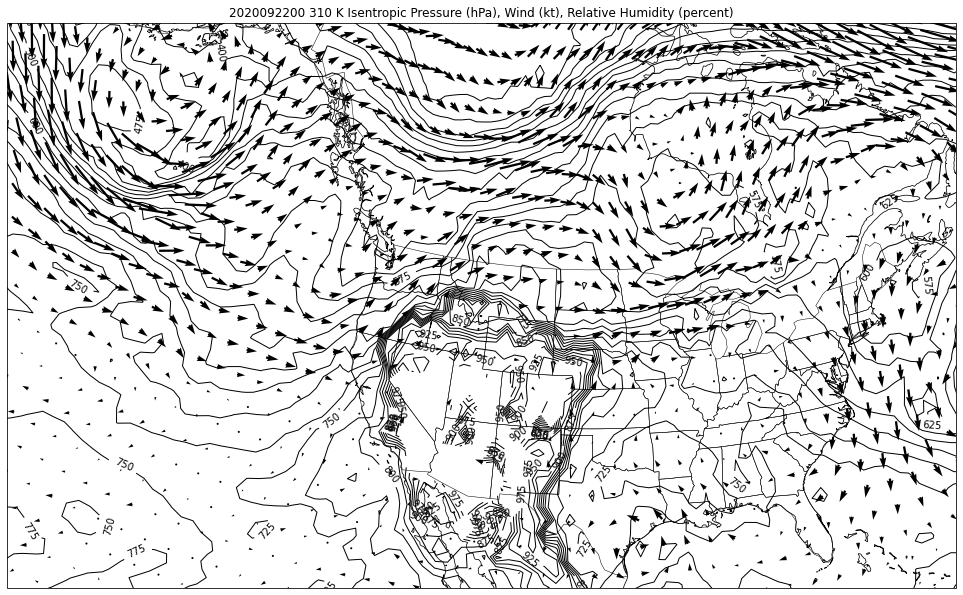

In [18]:
# Set up projection
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)

# Coordinates to limit map area
bounds = [(-150., -70., 25., 60.)]

fig = plt.figure(figsize=(17., 12.))
ax = fig.add_subplot(1, 1, 1, projection=crs)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=0.5)

#doing only for one level
level=0
# Plot the surface
clevisent = np.arange(50, 1000, 25)
cs = ax.contour(lon, lat, isenp[level, :, :], clevisent,
                colors='k', linewidths=1.0, linestyles='solid', transform=ccrs.PlateCarree())
ax.clabel(cs, fontsize=10, inline=1, inline_spacing=7,
          fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot RH
#cf = ax.contourf(lon, lat, isenrh[level, :, :], range(10, 106, 5),
#                 cmap=plt.cm.gist_earth_r, transform=ccrs.PlateCarree())
#cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=0.5, pad=0.05)
#cb.set_label('Relative Humidity', size='x-large')

# Plot vectors
isu = isenu[level,:,:]
isv = isenv[level,:,:]
skip1 = (slice(None,None,2))
skip=(slice(None,None,2),slice(None,None,2))
plt.quiver(lon.values[skip1],lat.values[skip1],isu[skip].m,isv[skip].m,scale=75, scale_units='inches',pivot='tail',color='black',transform=ccrs.PlateCarree())

# Make some titles
le= isentlevs[level].m
ax.set_title(timestamp + ' {:.0f} K Isentropic Pressure (hPa), Wind (kt), Relative Humidity (percent)'
             .format(le))
plot_file = '../figs/gfs_isen_'+ str(le) + '_'+ timestamp + '.png'
plt.savefig(plot_file)
plt.show()